<div><div style="float:left; clear:both;"><img src="img/colab.png" align="left" width="200" height="200" /><br></div><div style="float:left; clear:both;"><a href="https://colab.research.google.com/drive/1ibh29tsjCfm8xoaSnSoG5bbVRC674h32">Abre este Jupyter en Google Colab</a></div></div>

# Caso Práctico: Redes Neuronales Artificiales (RNA)

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score

## Funciones auxiliares

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

## 1. Lectura del conjunto de datos

In [4]:
df = pd.read_csv("datasets/creditcard.csv")

## 2. Visualización del conjunto de datos

In [5]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [6]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


In [7]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


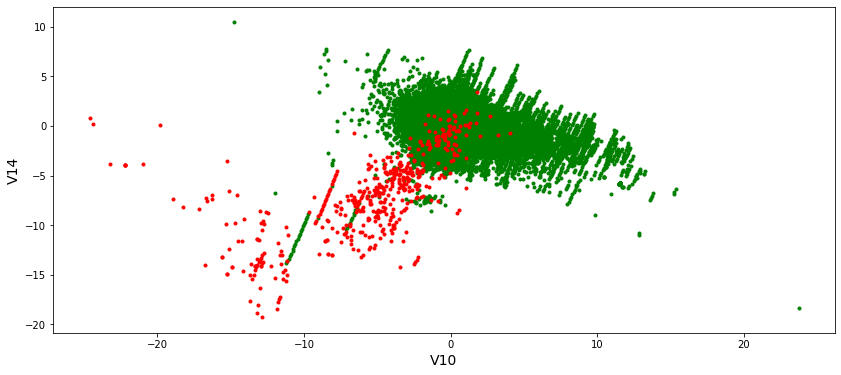

In [11]:
# Representación gráfica de dos características
plt.figure(figsize=(14, 6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class'] == 0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class'] == 1], c="r", marker=".")
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [12]:
df = df.drop(["Time", "Amount"], axis=1)

## 4. División del conjunto de datos

In [13]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [14]:
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

## 5. Redes Neuronales Artificiales con un conjunto de datos de dos dimensiones

Antes de comenzar con la detección de transacciones fraudulentas mediante Redes Neuronales Artificiales para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.

In [15]:
X_train_reduced = X_train[["V10", "V14"]].copy()
X_val_reduced = X_val[["V10", "V14"]].copy()
X_test_reduced = X_test[["V10", "V14"]].copy()

In [16]:
X_train_reduced

,V10,V14
164406,-0.975273,-0.115675
220383,0.919355,-0.505054
49922,-0.094516,-0.439746
181642,0.107004,0.565399
210715,-0.179247,-0.433966
...,...,...
119879,0.079128,0.600937
259178,-0.654029,0.384625
131932,-0.212753,-0.019493
146867,-0.027572,0.927786


**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
# Instalamos la librería adicional keras-metrics para simplificar el 
# cálculo de algunas métricas durante el entrenamiento del algoritmo
!pip install keras-metrics

In [17]:
# Definición de la arquitectura de la red neuronal
from keras import models
from keras import layers
import keras_metrics as km

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train_reduced.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=[km.f1_score()])

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


In [18]:
# Resumen de las capas del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Entrenamos el modelo
history = model.fit(X_train_reduced,
                   y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(X_val_reduced, y_val))

Train on 170884 samples, validate on 56961 samples
Epoch 1/40
170884/170884 [==============================] - 3s 19us/step - loss: 0.0387 - f1_score: 0.1220 - val_loss: 0.0040 - val_f1_score: 0.8491
Epoch 2/40
170884/170884 [==============================] - 2s 11us/step - loss: 0.0044 - f1_score: 0.7566 - val_loss: 0.0044 - val_f1_score: 0.8443
Epoch 3/40
170884/170884 [==============================] - 2s 12us/step - loss: 0.0042 - f1_score: 0.7655 - val_loss: 0.0041 - val_f1_score: 0.8009
Epoch 4/40
170884/170884 [==============================] - 2s 12us/step - loss: 0.0041 - f1_score: 0.7559 - val_loss: 0.0038 - val_f1_score: 0.7748
Epoch 5/40
170884/170884 [==============================] - 2s 13us/step - loss: 0.0040 - f1_score: 0.7205 - val_loss: 0.0042 - val_f1_score: 0.7495
Epoch 6/40
170884/170884 [==============================] - 2s 14us/step - loss: 0.0042 - f1_score: 0.7520 - val_loss: 0.0036 - val_f1_score: 0.7865
Epoch 7/40
170884/170884 [=============================

**Representación del límite de decisión**

In [20]:
def plot_ann_decision_boundary(X, y, model, steps=1000):
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = labels.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)

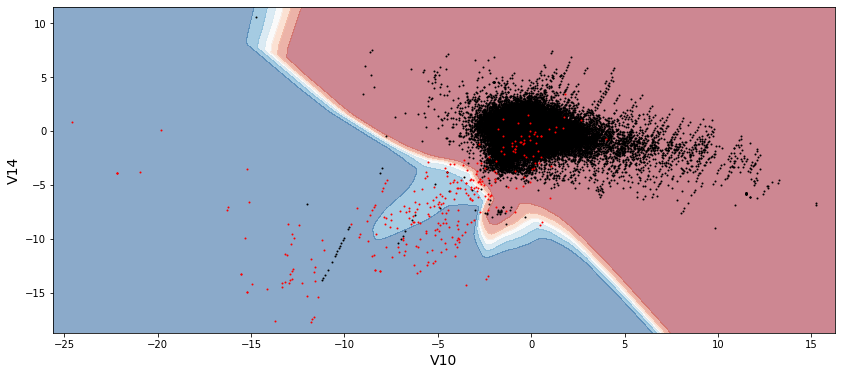

In [21]:
plt.figure(figsize=(14, 6))
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

**Representación de los ejemplos catalogados como maliciosos**

In [22]:
# Predicción con el conjunto de datos de entrenamiento
y_pred = model.predict_classes(X_train_reduced)

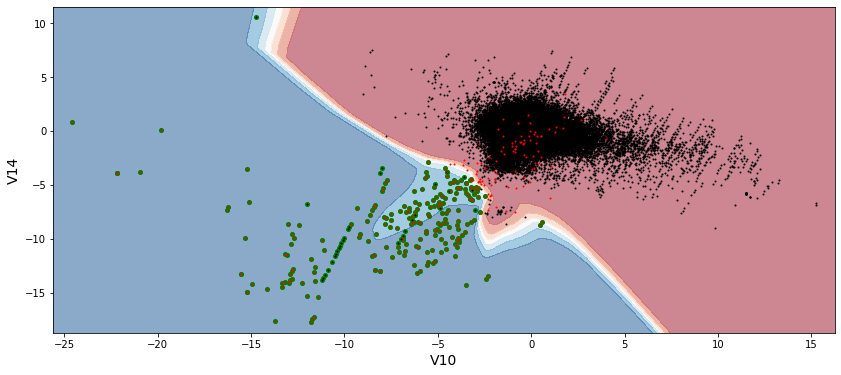

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(X_train_reduced[y_pred==1]["V10"], X_train_reduced[y_pred==1]["V14"], 'go', markersize=4)
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.xlabel("V10", fontsize=14)
plt.ylabel("V14", fontsize=14)
plt.show()

**Predicción con el conjunto de datos reducido**

In [24]:
# Predicción con el conjunto de datos de prueba
y_pred = model.predict_classes(X_test_reduced)

In [25]:
print("F1 Score:", f1_score(y_test, y_pred))

F1 Score: 0.8181818181818182


## 6. Redes Neuronales Artificiales con un conjunto de datos multidimensional

### Aplicamos selección de características con Random Forest

In [26]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [27]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(X_train), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(10)

V17    0.243084
V14    0.132483
V12    0.093218
V11    0.066528
V16    0.066408
V10    0.059194
V18    0.034266
V9     0.030143
V4     0.025466
V7     0.020946
dtype: float64

In [28]:
# Reducimos el conjunto de datos a las 10 características más importantes
features = list(feature_importances_sorted.head(20).index)
X_train_select = X_train[features].copy()
X_val_select = X_val[features].copy()
X_test_select = X_test[features].copy()
X_train_select

,V17,V14,V12,V11,V16,V10,V18,V9,V4,V7,V1,V15,V20,V6,V21,V3,V26,V8,V27,V5
164406,-1.209313,-0.115675,-0.589246,-1.850664,0.954582,-0.975273,0.640636,0.226930,-0.779271,0.176700,-1.509348,0.337068,0.502244,-0.250687,0.369591,1.089287,0.288080,0.211197,-0.023211,1.213151
220383,-0.685169,-0.505054,-0.440400,-0.752344,0.794032,0.919355,-0.031408,-0.965050,2.972199,0.497715,-0.855208,-0.981423,-0.358988,0.195791,1.074965,2.563111,-0.011914,-0.915033,-0.087454,-0.187680
49922,-1.121411,-0.439746,-0.361721,-0.942655,1.077567,-0.094516,0.342143,-0.612186,0.455518,-0.402337,-1.082417,-0.652224,-0.028980,4.381102,-0.069963,1.375652,-0.119972,1.227511,-0.072594,2.471959
181642,-0.107078,0.565399,-0.035721,-1.144233,-0.494280,0.107004,-0.658594,0.450298,0.672408,0.612810,1.898722,-0.368894,-0.082106,-1.267347,0.015111,-1.771837,0.378225,-0.441070,-0.106042,0.115019
210715,0.349047,-0.433966,0.355078,1.124602,0.505890,-0.179247,0.251416,0.375881,0.354859,0.016307,2.019857,-0.397238,-0.218017,-0.688151,-0.312851,-1.623959,0.146084,-0.043346,-0.072767,0.291940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.356782,0.600937,0.777009,1.585195,0.239566,0.079128,-0.410923,-0.114199,0.461596,-0.165254,1.173488,0.658885,-0.157534,-0.213165,-0.186027,0.490512,0.109235,0.119221,-0.020922,-0.296377
259178,-0.462528,0.384625,0.346437,-0.421422,0.057999,-0.654029,-0.063197,0.400697,-1.241113,-0.466107,-0.775981,0.785702,-0.295730,3.912076,0.037078,-1.142399,-0.770941,1.360620,0.066006,1.940358
131932,-0.539887,-0.019493,0.022804,-0.382362,-0.144778,-0.212753,-0.068375,-0.491303,0.485774,1.076640,-0.146609,0.690200,0.007155,-0.815198,0.052649,1.524591,-0.398467,-0.395316,-0.121139,0.349308
146867,-0.396148,0.927786,0.570400,-0.418939,0.426113,-0.027572,-0.946837,0.580199,-3.798905,-0.471769,-2.948638,-0.090065,0.417396,2.727695,-0.332759,-2.521201,0.426309,2.217537,0.496912,1.866302


### Entrenamiento del algoritmo RNA

In [29]:
# Entrenamiento del algoritmo
model = models.Sequential()

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train_select.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=[km.f1_score()])

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 13,569
Trainable params: 13,569
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Entrenamos el algoritmo
history = model.fit(X_train_select,
                   y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(X_val_select, y_val))

Train on 170884 samples, validate on 56961 samples
Epoch 1/40
170884/170884 [==============================] - 3s 20us/step - loss: 0.0135 - f1_score: 0.4324 - val_loss: 0.0039 - val_f1_score: 0.7955
Epoch 2/40
170884/170884 [==============================] - 2s 13us/step - loss: 0.0036 - f1_score: 0.8361 - val_loss: 0.0036 - val_f1_score: 0.7979
Epoch 3/40
170884/170884 [==============================] - 2s 14us/step - loss: 0.0035 - f1_score: 0.8055 - val_loss: 0.0033 - val_f1_score: 0.7970
Epoch 4/40
170884/170884 [==============================] - 2s 14us/step - loss: 0.0032 - f1_score: 0.7936 - val_loss: 0.0033 - val_f1_score: 0.8414
Epoch 5/40
170884/170884 [==============================] - 2s 13us/step - loss: 0.0030 - f1_score: 0.8273 - val_loss: 0.0034 - val_f1_score: 0.8406
Epoch 6/40
170884/170884 [==============================] - 2s 13us/step - loss: 0.0028 - f1_score: 0.8552 - val_loss: 0.0032 - val_f1_score: 0.7028
Epoch 7/40
170884/170884 [=============================

In [32]:
# Predicción con el conjunto de datos de prueba
y_pred = model.predict_classes(X_test_select)

In [33]:
print("F1 Score:", f1_score(y_test, y_pred))

F1 Score: 0.8351648351648352
